In [74]:
### Reading Data

import pandas as pd

train_data = pd.read_csv('train_selected.csv')
test_data = pd.read_csv('test_selected.csv')

# Loading true TTF values
with open('PM_truth.txt', 'r') as file:
    y_test_truth = [int(line.strip()) for line in file]
    y_test_truth = np.array(y_test_truth)

In [75]:
from sklearn.preprocessing import MinMaxScaler

# Extract relevant columns
train_features = train_data[['s1', 's2', 's3', 's4']]
train_cycles = train_data['cycle']
train_ttf = train_data['ttf']
train_class_label = train_data['label_bnc']

test_features = test_data[['s1', 's2', 's3', 's4']]
test_cycles = test_data['cycle']

# Normalize the sensor data using Min-Max Scaling
scaler = MinMaxScaler()

#transform both train and test data
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Convert back to DataFrames and combine
train_features_scaled = pd.DataFrame(train_features_scaled, columns=['s1', 's2', 's3', 's4'])
test_features_scaled = pd.DataFrame(test_features_scaled, columns=['s1', 's2', 's3', 's4'])
train_preprocessed = pd.concat([train_data['id'], train_cycles, train_features_scaled, train_ttf, train_class_label], axis=1)
test_preprocessed = pd.concat([test_data['id'], test_cycles, test_features_scaled], axis=1)


In [103]:
### Random Forest

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prepare the features and target
X_train = train_preprocessed[['cycle', 's1', 's2', 's3', 's4']]
y_train = train_preprocessed['ttf']  # Target: TTF (time to failure)

# Train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=500, 
                                     max_features='sqrt', 
                                     max_depth=7, 
                                     min_samples_leaf=5, 
                                     min_samples_split=2, 
                                     random_state=42
                                    )
rf_regressor.fit(X_train, y_train)

# Predict TTF on the test data
X_test = test_preprocessed[['cycle', 's1', 's2', 's3', 's4']]
y_test_pred = rf_regressor.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_truth, y_test_pred))
mae = mean_absolute_error(y_test_truth, y_test_pred)
r2 = r2_score(y_test_truth, y_test_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 27.705863855697704
MAE: 22.085949395257213
R-squared: 0.5554876338141244


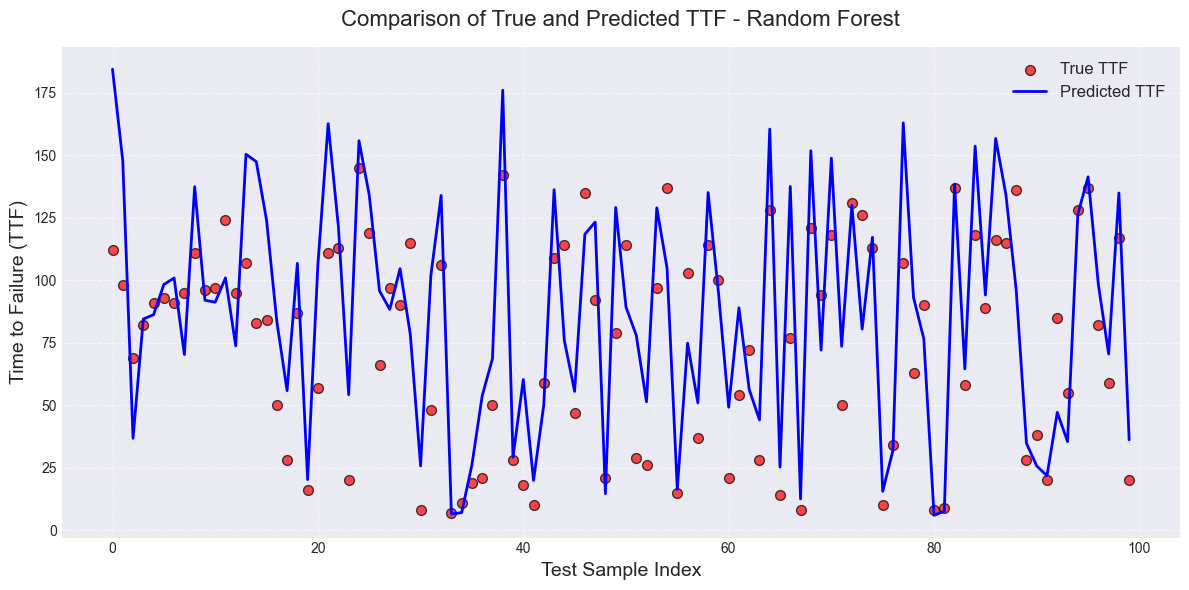

In [104]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test_truth)), y_test_truth, color='red', alpha=0.7, edgecolor='k', s=50, label='True TTF')
plt.plot(range(len(y_test_pred)), y_test_pred, color='blue', linewidth=2, label='Predicted TTF')

plt.title('Comparison of True and Predicted TTF - Random Forest', fontsize=16, pad=15)
plt.xlabel('Test Sample Index', fontsize=14)
plt.ylabel('Time to Failure (TTF)', fontsize=14)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

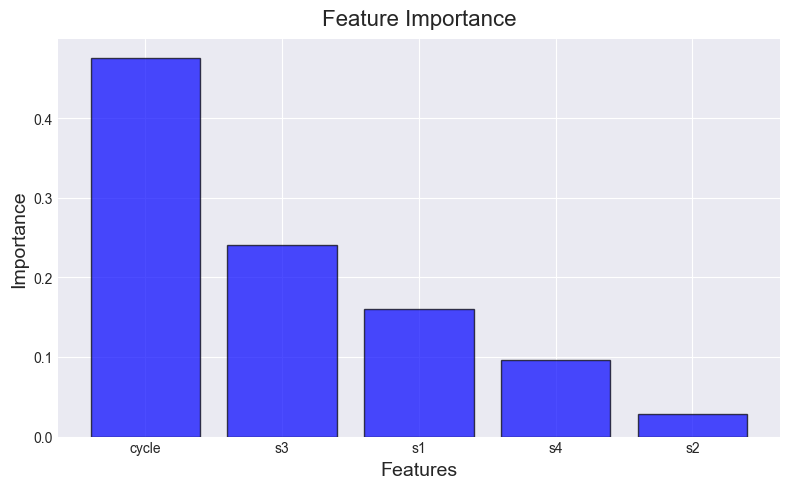

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importances from the Random Forest model
features = ['cycle', 's1', 's2', 's3', 's4']
importances = rf_regressor.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(8, 5))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='blue', alpha=0.7, edgecolor='k')
plt.title('Feature Importance', fontsize=16, pad=10)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.tight_layout()
plt.show()


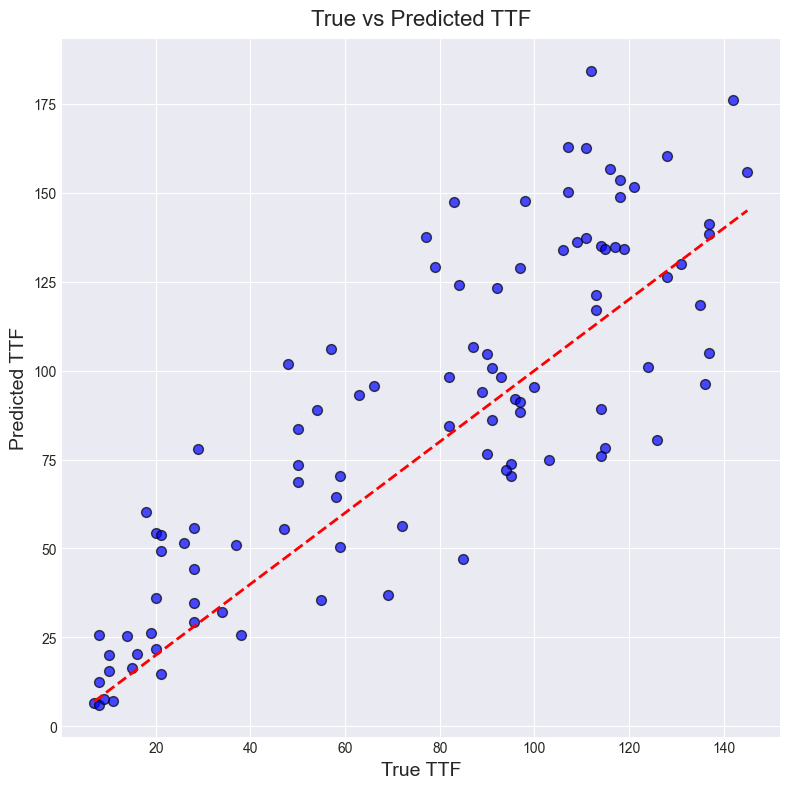

In [63]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(8, 8))
plt.scatter(y_test_truth, y_test_pred, color='blue', alpha=0.7, edgecolor='k', s=50)
plt.plot([min(y_test_truth), max(y_test_truth)], [min(y_test_truth), max(y_test_truth)], color='red', linestyle='--', linewidth=2)
plt.title('True vs Predicted TTF', fontsize=16, pad=10)
plt.xlabel('True TTF', fontsize=14)
plt.ylabel('Predicted TTF', fontsize=14)
plt.tight_layout()
plt.show()


In [57]:
### Random Forest GridSearch
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [7, 5, 3],
    'max_features': ['sqrt', None, 'log2']
}
# Initialise random forest
rf = RandomForestRegressor(random_state=42)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='neg_root_mean_squared_error', 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=1)

grid_search.fit(X_train, y_train)

# Extract the best model, predict and calulate metrics
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test_truth, y_pred))
mae = mean_absolute_error(y_test_truth, y_pred)
r2 = r2_score(y_test_truth, y_pred)

# Output results
print("Best Parameters:", grid_search.best_params_)
print(f"\nPerformance of Best Random Forest Model:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared: {r2:.2f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500}

Performance of Best Random Forest Model:
RMSE: 27.71
MAE: 22.09
R-squared: 0.56


In [99]:
from sklearn.linear_model import LinearRegression

# Prepare the features and target
X_train = train_preprocessed[['cycle', 's1', 's2', 's3', 's4']]
y_train = train_preprocessed['ttf']
X_test = test_preprocessed[['cycle', 's1', 's2', 's3', 's4']]

# Train the Linear Regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predict TTF on the test data
y_test_pred_linear = linear_regressor.predict(X_test)

# Evaluate the model
rmse_linear = np.sqrt(mean_squared_error(y_test_truth, y_test_pred_linear))
mae_linear = mean_absolute_error(y_test_truth, y_test_pred_linear)
r2_linear = r2_score(y_test_truth, y_test_pred_linear)

# Print the evaluation metrics
print(f"Linear Regression - RMSE: {rmse_linear:.3f}")
print(f"Linear Regression - MAE: {mae_linear:.3f}")
print(f"Linear Regression - R-squared: {r2_linear:.3f}")

Linear Regression - RMSE: 32.361
Linear Regression - MAE: 26.998
Linear Regression - R-squared: 0.394


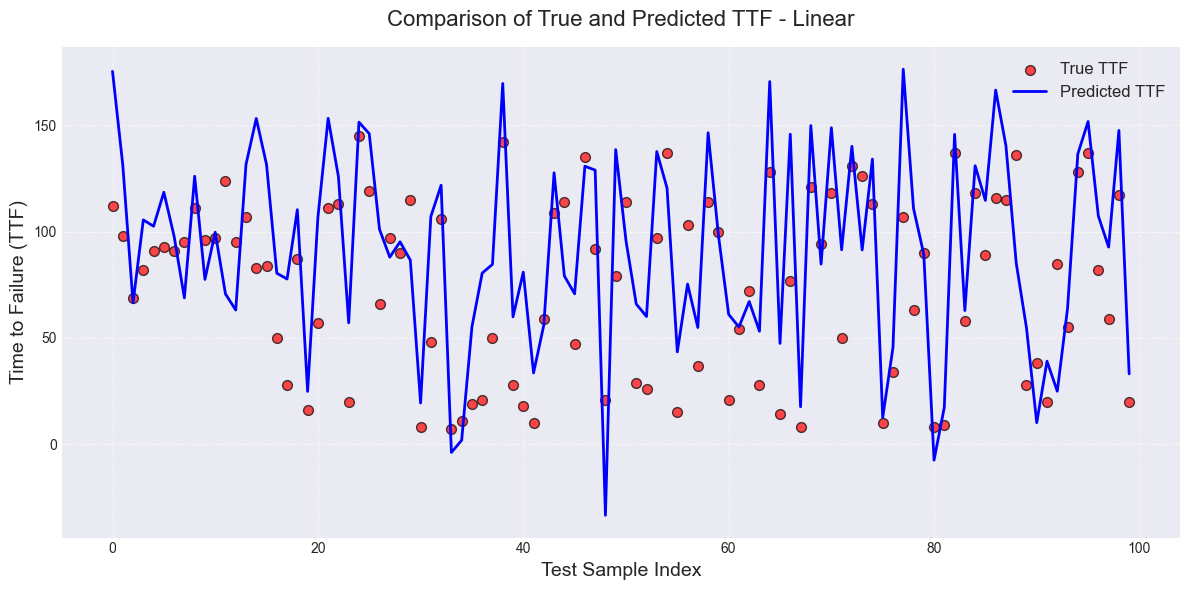

In [100]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test_truth)), y_test_truth, color='red', alpha=0.7, edgecolor='k', s=50, label='True TTF')
plt.plot(range(len(y_test_pred_linear)), y_test_pred_linear, color='blue', linewidth=2, label='Predicted TTF')

plt.title('Comparison of True and Predicted TTF - Linear', fontsize=16, pad=15)
plt.xlabel('Test Sample Index', fontsize=14)
plt.ylabel('Time to Failure (TTF)', fontsize=14)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

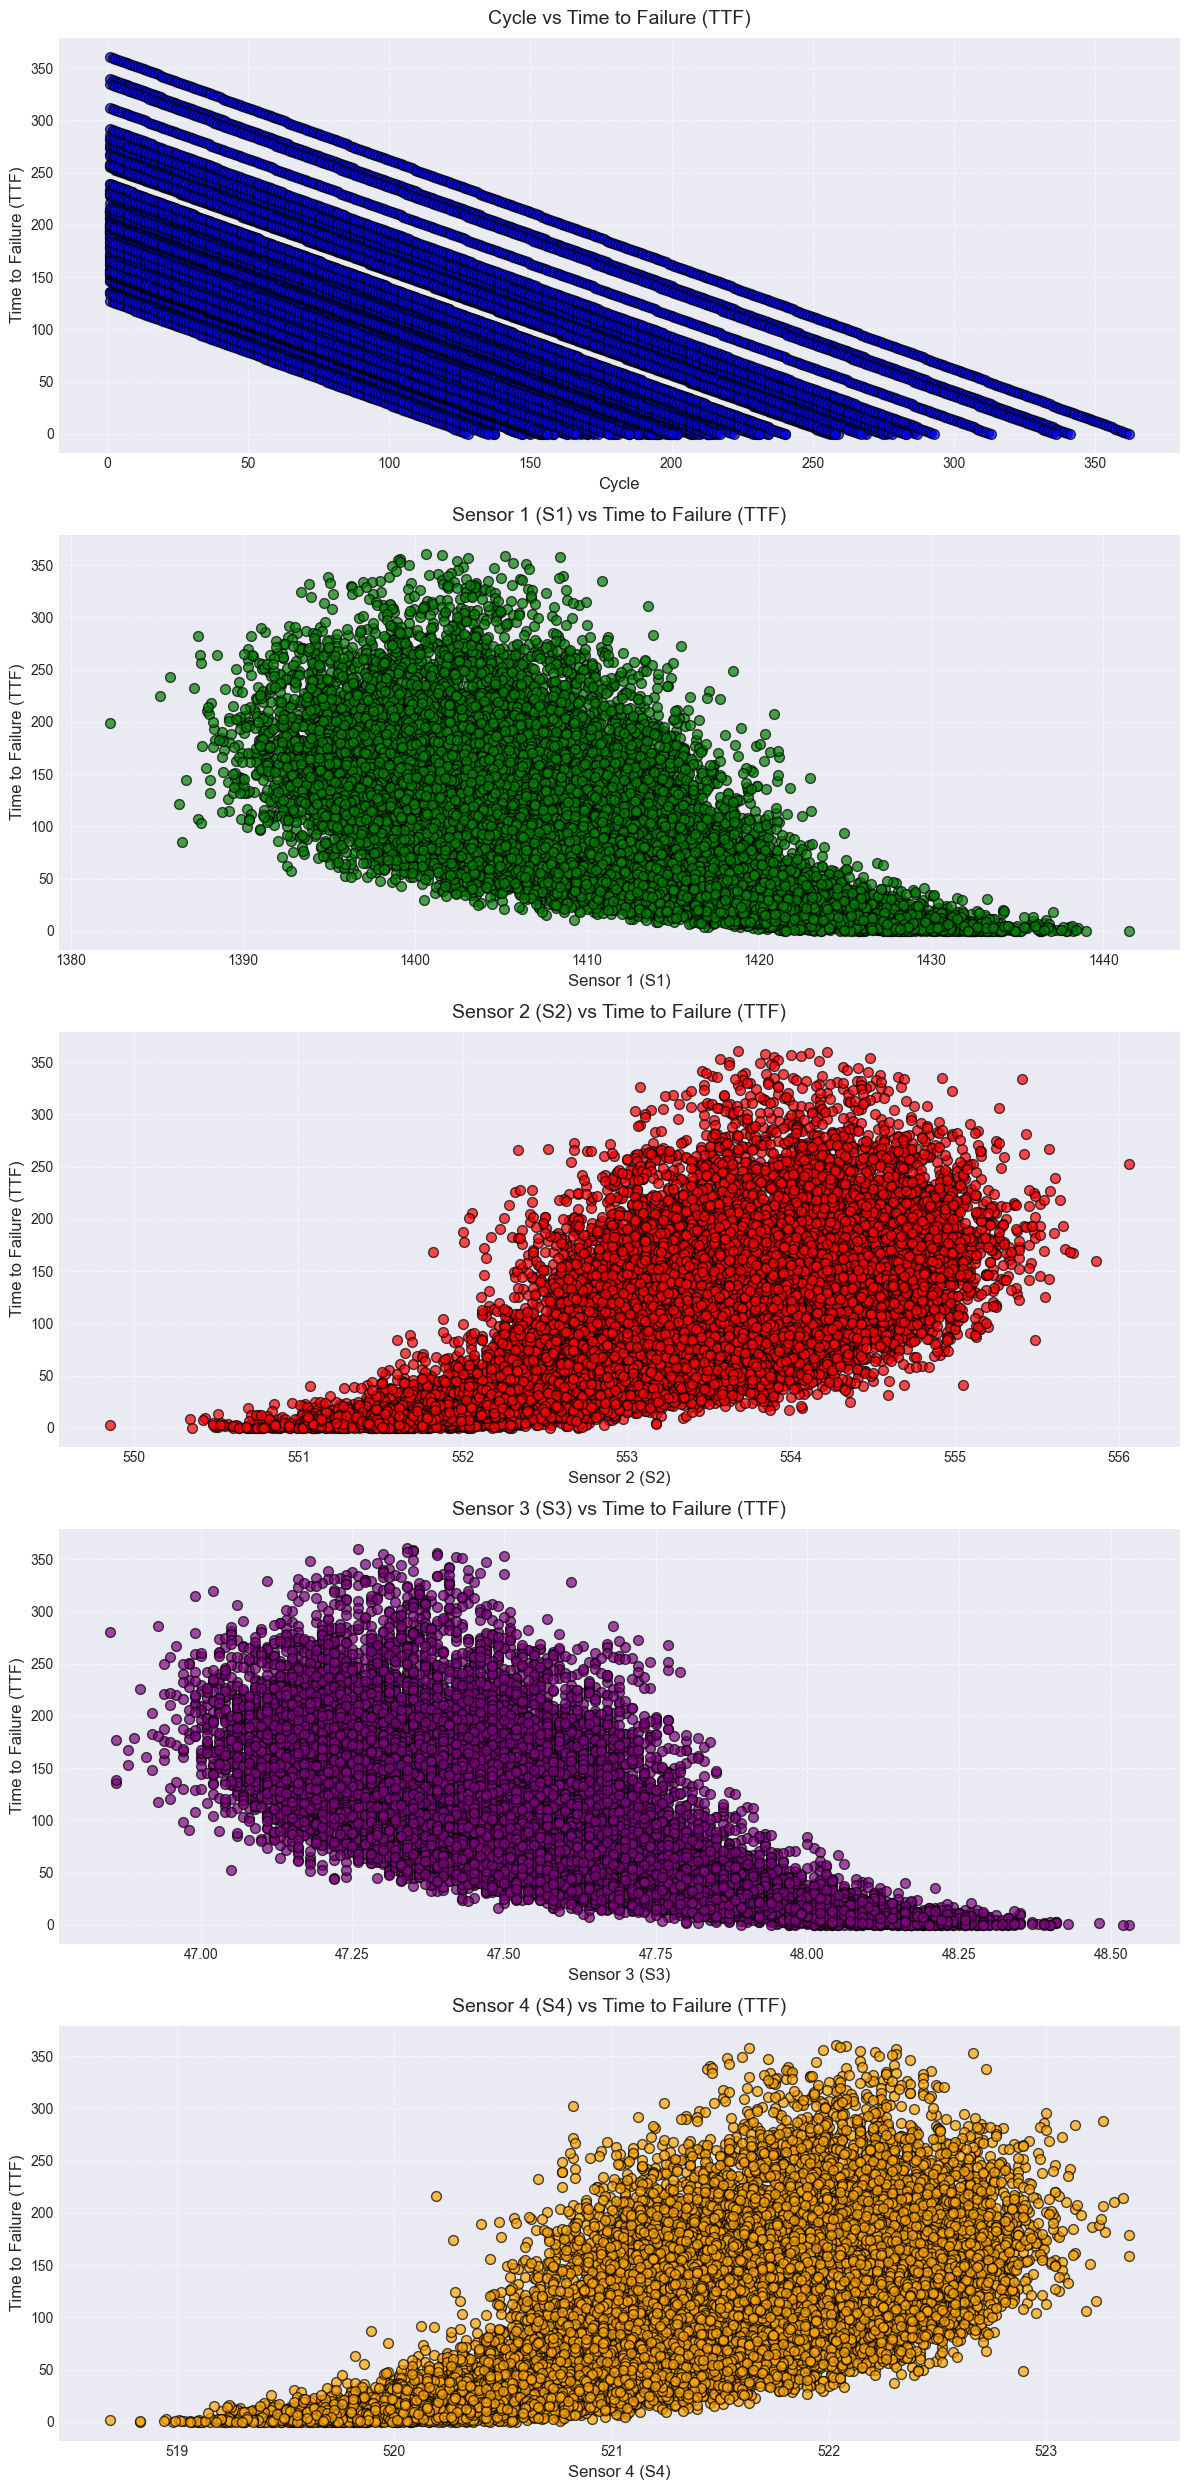

In [66]:
### Plots for all variables vs TTF

import matplotlib.pyplot as plt

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Variables to plot
variables = ['cycle', 's1', 's2', 's3', 's4']
variable_labels = {
    'cycle': 'Cycle',
    's1': 'Sensor 1 (S1)',
    's2': 'Sensor 2 (S2)',
    's3': 'Sensor 3 (S3)',
    's4': 'Sensor 4 (S4)'
}

colors = ['blue', 'green', 'red', 'purple', 'orange']

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 25), sharex=False)

# Generate scatter plots
for idx, (variable, color) in enumerate(zip(variables, colors)):
    axs[idx].scatter(train_data[variable], train_data['ttf'], c=color, alpha=0.7, edgecolor='k', s=50)
    axs[idx].set_title(f'{variable_labels[variable]} vs Time to Failure (TTF)', fontsize=14, pad=10)
    axs[idx].set_xlabel(variable_labels[variable], fontsize=12)
    axs[idx].set_ylabel('Time to Failure (TTF)', fontsize=12)
    axs[idx].grid(visible=True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

